## Analysing and Preparing Data

###Charging Data

In [5]:
# Basic example loading images from the svhn dataset

# Dictionaries
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
from nltk.corpus import stopwords
import string

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/DeepLearning_2022/PROJECT/Data/'
results_path = '/content/drive/Shared drives/DeepLearning_2022/PROJECT/Results/'

import csv

# Charge the data

#we read the dataset Sentiment140 for tweet polarity --> 1M tweets
data_polarity = pd.read_csv(data_path+'Sentiment140.csv',encoding='utf-8')

#we read the datasets
data_emoji = pd.read_csv(data_path+'emoticons_polarity_emotion_filtered.csv', index_col = 0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Preparing Data Polarity Data

In [6]:
# rename the columns
data_polarity.columns = ['polarity','id','date','no_query','username','tweet']
print(data_polarity.columns)

# only keeps polarity and tweet
data_p = data_polarity[['polarity','tweet']]
print(data_p)

Index(['polarity', 'id', 'date', 'no_query', 'username', 'tweet'], dtype='object')
         polarity                                              tweet
0               0  is upset that he can't update his Facebook by ...
1               0  @Kenichan I dived many times for the ball. Man...
2               0    my whole body feels itchy and like its on fire 
3               0  @nationwideclass no, it's not behaving at all....
4               0                      @Kwesidei not the whole crew 
...           ...                                                ...
1048568         4           My GrandMa is making Dinenr with my Mum 
1048569         4  Mid-morning snack time... A bowl of cheese noo...
1048570         4  @ShaDeLa same here  say it like from the Termi...
1048571         4             @DestinyHope92 im great thaanks  wbuu?
1048572         4               cant wait til her date this weekend 

[1048573 rows x 2 columns]


In [7]:
#positive: 1
#negative: 0
# More negative than positive values, dangerous, maybe good idea to reduce negative amount of data
data_p["polarity"] = data_p["polarity"]/4
data_p["polarity"].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.0    799997
1.0    248576
Name: polarity, dtype: int64

In [8]:
data_p_r = data_p

In [9]:
# shuffle the data for not having it in order
from sklearn.utils import shuffle
data_p_r = shuffle(data_p_r)
print(data_p_r["polarity"].value_counts())
print(data_p_r)

0.0    799997
1.0    248576
Name: polarity, dtype: int64
        polarity                                              tweet
114686       0.0  i really hope nothing bad happens today, last ...
600013       0.0  Goin out 2 get my hair done needs a good cut h...
890511       1.0  Covered the basics on here, got Nfl network, e...
503548       0.0  hungry  someone please bring me leftovers from...
875767       1.0       had a good day, feel weird.. in a good way. 
...          ...                                                ...
117395       0.0  @crankyknitter How was your night? Sorry about...
420353       0.0  is depressed. The sun is out! Where did all th...
320781       0.0               @decaydance I'm so gutted about Ian 
945245       1.0  http://twitpic.com/55s4x - this is what i get ...
15350        0.0  So all #RSD09 exclusives were sold out/too exp...

[1048573 rows x 2 columns]


In [10]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
#clean tweets 
a = 'a ' + data_p_r.loc[0,'tweet']
a = re.sub("(?:\s)@[^, ]*", '', a)
a = a[2:]

In [12]:
import re

all_tweets_p = list()
for t in data_p_r["tweet"]:
  t = 'a ' + t
  t = re.sub("(?:\s)@[^, ]*", '', t)
  t = t[2:]
  t = t.lower()
  t = "".join([ch for ch in t if ch not in punctuation])
  all_tweets_p.append(t)
all_text = " ".join(all_tweets_p)
all_words = all_text.split()

In [13]:
from collections import Counter 
# Count all the words using Counter Method
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)
print("Top ten occuring words : ",sorted_words[:10])

Top ten occuring words :  [('i', 551053), ('to', 392771), ('the', 337684), ('a', 243165), ('my', 227482), ('and', 197269), ('is', 161948), ('it', 154314), ('you', 149188), ('in', 145437)]


In [14]:
vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}

In [15]:
encoded_tweets=list()
iter_1 = 0
iter_2 = 0
for t in all_tweets_p:
  encoded_tweet=list()
  for word in t.split():
    if word not in vocab_to_int.keys():
      #if word is not available in vocab_to_int put 0 in that position
      encoded_tweet.append(0)
      iter_1 += 1
    else:
      iter_2 += 1
      encoded_tweet.append(vocab_to_int[word])
  encoded_tweets.append(encoded_tweet)
print(iter_1)
print(iter_2)
print(encoded_tweets[0])

0
13456224
[1, 48, 104, 230, 95, 912, 43, 77, 80, 629, 14]


In [16]:
sequence_length = 0
#set sequence_length to the largest tweet
for i, tweet in enumerate(encoded_tweets):
  if len(tweet) > sequence_length:
    sequence_length = len(tweet)

features = []
for i, tweet in enumerate(encoded_tweets):
  tweet_len=len(tweet)
  #add zeros to the tweet until reaching sequence_length
  if (tweet_len<=sequence_length):
    zeros=list(np.zeros(sequence_length-tweet_len))
    new=zeros+tweet
  #make the tweet shorter (since sequence_length is the largest tweet this should not happen) 
  else:
    new=tweet[:sequence_length]
  features.append(np.array(new))

### Preparing Data Emoji

In [17]:
# Again not all types have the same number of data, dangerous
print(data_emoji)
print(data_emoji["emotion"].value_counts())

                                                  tweet  \
0     The woman who was forced into child labour dur...   
1     A group of children who fled #Mariupol are now...   
2     @MZavala86 @RT_com Dictator Vladimir Putin has...   
3     Yesterday in Brussels during a peaceful strike...   
4     😡 The Russians who left the #Chornobyl nuclear...   
...                                                 ...   
2068  Let’s stop the russian spelling and name it th...   
2069  #Lysychansk after #Putin 🤬 #Лисичанськ #Україн...   
2070  This is really brutal! 🤬\n\nA Ukrainian office...   
2071  Hey #Germany! Are you going to start using #pe...   
2072  Go figure ...India won't condemn Russia for (t...   

                          emoji  polarity  emotion  
0                         ['😭']         0        3  
1                         ['😭']         0        3  
2                         ['😂']         1        1  
3                         ['😓']         0        3  
4                         

###Analysing tweets

In [18]:
#split_dataset into 80% training , 10% test and 10% Validation Dataset
train_x=features[:int(0.8*len(features))]
train_y=data_p_r["polarity"][:int(0.8*len(features))]
valid_x=features[int(0.8*len(features)):int(0.9*len(features))]
valid_y=data_p_r["polarity"][int(0.8*len(features)):int(0.9*len(features))]
test_x=features[int(0.9*len(features)):]
test_y=data_p_r["polarity"][int(0.9*len(features)):]

##Train the model

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(train_x).to(torch.int64), torch.FloatTensor(train_y.to_numpy(dtype=np.float64)).to(torch.int64))
valid_data=TensorDataset(torch.FloatTensor(valid_x).to(torch.int64), torch.FloatTensor(valid_y.to_numpy(dtype=np.float64)).to(torch.int64))
test_data=TensorDataset(torch.FloatTensor(test_x).to(torch.int64), torch.FloatTensor(test_y.to_numpy(dtype=np.float64)).to(torch.int64))

#dataloader
#batch size tune: 256
batch_size=256
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  """


In [20]:
import torch.nn as nn
 
class LSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        #dropout layer
        self.dropout=nn.Dropout(0.5) #dropout tune: 0.5

        #Embedding and LSTM layers
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        #Linear layers
        self.fc1=nn.Linear(hidden_dim, output_size)
        #self.fc1=nn.Linear(hidden_dim, 128)
        #self.fc2=nn.Linear(128, 64) 
        #self.fc3=nn.Linear(64,output_size) --> worse results

        #Sigmoid activation function
        self.sigmoid=nn.Sigmoid()

        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()
        
        #Embadding and LSTM output
        embedd=self.embedding(x)
        lstm_out, hidden=self.lstm(embedd, hidden)
        
        #stack up the lstm output
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)

        #out=self.dropout(out)
        #out=self.fc2(out)
        #out=self.dropout(out)
        #out=self.fc3(out) --> worse results

        #sigmoid layer
        sig_out=self.sigmoid(out)

        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors of size n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [21]:
# Instantiate the model
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 500
n_layers = 2

net = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

LSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(361442, 400)
  (lstm): LSTM(400, 500, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [23]:
counter=0
#learning rate
lr=0.0001

# loss and optimization functions
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params

epochs = 3 

training_loss=[]
validation_loss=[]


print_every = 200
# gradient clipping
clip=5 

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter+=1
        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()
        # Creating new variables for the hidden state, otherwise
        # we'd backpropagate through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        try:
          # get the output
          output, h = net(inputs, h)

          # calculate the loss and backpropagate
          loss = criterion(output.squeeze(), labels.float())
          loss.backward()
          # clip_grad_norm to prevent the exploding gradient problem in RNNs / LSTMs.
          nn.utils.clip_grad_norm_(net.parameters(), clip)
          optimizer.step()
        except:
          pass

        # validation
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])
                if(train_on_gpu):
                  inputs, labels = inputs.cuda(), labels.cuda()  
                
                try:
                  output, val_h = net(inputs, val_h)
                  val_loss = criterion(output.squeeze(), labels.float())
                  val_losses.append(val_loss.item())
                except:
                  pass
            training_loss.append(loss)
            validation_loss.append(np.mean(val_losses))
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))


Epoch: 1/3... Step: 200... Loss: 0.117918... Val Loss: 0.151779
Epoch: 1/3... Step: 400... Loss: 0.147743... Val Loss: 0.140584
Epoch: 1/3... Step: 600... Loss: 0.130649... Val Loss: 0.134351
Epoch: 1/3... Step: 800... Loss: 0.130461... Val Loss: 0.130570
Epoch: 1/3... Step: 1000... Loss: 0.143801... Val Loss: 0.127142
Epoch: 1/3... Step: 1200... Loss: 0.136410... Val Loss: 0.124702
Epoch: 1/3... Step: 1400... Loss: 0.112914... Val Loss: 0.123707
Epoch: 1/3... Step: 1600... Loss: 0.140418... Val Loss: 0.126698
Epoch: 1/3... Step: 1800... Loss: 0.117936... Val Loss: 0.120061
Epoch: 1/3... Step: 2000... Loss: 0.125088... Val Loss: 0.118821
Epoch: 1/3... Step: 2200... Loss: 0.106104... Val Loss: 0.118148
Epoch: 1/3... Step: 2400... Loss: 0.111174... Val Loss: 0.118869
Epoch: 1/3... Step: 2600... Loss: 0.116908... Val Loss: 0.117981
Epoch: 1/3... Step: 2800... Loss: 0.121927... Val Loss: 0.117019
Epoch: 1/3... Step: 3000... Loss: 0.099726... Val Loss: 0.117286
Epoch: 1/3... Step: 3200... L

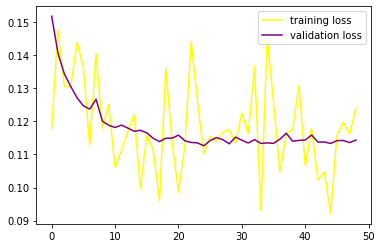

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


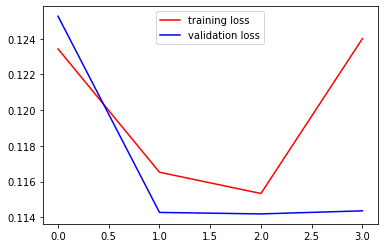

In [24]:
#plot of losses over steps --> #step = x axis value * 200
t1 = []
for i in training_loss:
  t1.append(i.cpu().item())


plt.plot(t1,'yellow', label="training loss")
plt.plot(validation_loss, 'purple', label="validation loss")
plt.legend()
plt.show()

#plot of losses over epochs
t = []
v = []
for i in range(0,6):
  v.append(np.mean(validation_loss[i*16:(i+1)*16]))
  t.append(np.mean(t1[i*16:(i+1)*16]))

plt.plot(t,'red',label='training loss')
plt.plot(v, 'blue', label='validation loss')

plt.legend()
plt.show()

In [25]:
#test
test_losses = []
num_correct = 0
num_pos_correct = 0
num_neg_correct = 0
total_p = 0
total_n = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test dataset
for inputs, labels in test_loader:

  h = tuple([each.data for each in h])

  if(train_on_gpu):
    inputs, labels = inputs.cuda(), labels.cuda()

  try:
    output, h = net(inputs, h)

    # calculate test loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    #count the correct and total predictions for each of the polarities (0,1)
    for i in range(256):
      if labels.float()[i]==1:
        total_p +=1
        correct_tensor = pred.eq(labels.float()[i].view_as(pred[i]))
        correct = np.squeeze(correct_tensor[i].numpy()) if not train_on_gpu else np.squeeze(correct_tensor[i].cpu().numpy())
        num_pos_correct += np.sum(correct)
      if labels.float()[i]==0:
        total_n +=1
        correct_tensor = pred.eq(labels.float()[i].view_as(pred[i]))
        correct = np.squeeze(correct_tensor[i].numpy()) if not train_on_gpu else np.squeeze(correct_tensor[i].cpu().numpy())
        num_neg_correct += np.sum(correct)
  except:
    pass

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data and accuracy of each of the polarities
test_acc = num_correct/len(test_loader.dataset)
test_acc_p = num_pos_correct/total_p
test_acc_n = num_neg_correct/total_n
print("Test accuracy: {:.3f}".format(test_acc))
print("Test positive accuracy: {:.6f}".format(test_acc_p))
print("Test negative accuracy: {:.6f}".format(test_acc_n))

Test loss: 0.117
Test accuracy: 0.838
Test positive accuracy: 0.559033
Test negative accuracy: 0.927557


##Clean the Ucraine-Russia dataset and use it for polarity testing

In [26]:
#clean the tweets
a = 'a ' + data_emoji.loc[0,'tweet']
a = re.sub("(?:\s)@[^, ]*", '', a)
a = a[2:]

In [27]:
import re

all_tweets_u = list()
for t in data_emoji["tweet"]:
  t = 'a ' + t
  t = re.sub("(?:\s)@[^, ]*", '', t)
  t = t[2:]
  t = t.lower()
  t = "".join([ch for ch in t if ch not in punctuation])
  all_tweets_u.append(t)
all_text = " ".join(all_tweets_u)
all_words = all_text.split()

In [28]:
#encode the tweets
encoded_tweets=list()
iter_1 = 0
iter_2 = 0
for t in all_tweets_u:
  encoded_tweet=list()
  for word in t.split():
    if word not in vocab_to_int.keys():
      #if word is not available in vocab_to_int put 0 in that place
      encoded_tweet.append(0)
      iter_1 += 1
    else:
      iter_2 += 1
      encoded_tweet.append(vocab_to_int[word])
  encoded_tweets.append(encoded_tweet)
print(iter_1)
print(iter_2)
print(encoded_tweets[0])

11618
43012
[3, 1318, 179, 25, 2310, 232, 1700, 7213, 778, 21675, 6, 28, 7, 2310, 2, 289, 100, 66, 0, 27, 853, 81, 7, 4, 2888, 68408, 2, 100, 1497, 16595, 3, 0, 13, 100, 190, 0, 6440, 780, 49, 19866, 120, 0]


In [29]:
sequence_length = 0
for i, tweet in enumerate(encoded_tweets):
  if len(tweet) > sequence_length:
    sequence_length = len(tweet)

features = []
for i, tweet in enumerate(encoded_tweets):
  tweet_len=len(tweet)
  if (tweet_len<=sequence_length):
    zeros=list(np.zeros(sequence_length-tweet_len))
    new=zeros+tweet
  else:
    new=tweet[:sequence_length]
  features.append(np.array(new))

In [30]:
import torch
from torch.utils.data import DataLoader, TensorDataset

test_x_u=features[:int(len(features))]
test_y_u=data_emoji["polarity"][:int(len(features))]

#create Tensor Dataset
test_data_u=TensorDataset(torch.FloatTensor(test_x_u).to(torch.int64), torch.FloatTensor(test_y_u.to_numpy(dtype=np.float64)).to(torch.int64))

#dataloader
batch_size=64
test_loader_u=DataLoader(test_data_u, batch_size=batch_size, shuffle=True)

In [31]:
test_losses = [] # track loss
num_correct = 0
num_pos_correct = 0
num_neg_correct = 0
total_p = 0
total_n = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader_u:

  # Creating new variables for the hidden state, otherwise
  # we'd backprop through the entire training history
  h = tuple([each.data for each in h])
  e=0

  if(train_on_gpu):
    inputs, labels = inputs.cuda(), labels.cuda()

  try:
    output, h = net(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    #count the correct values for each of the polarities
    for i in range(64):
      if labels.float()[i]==1:
        total_p +=1
        correct_tensor = pred.eq(labels.float()[i].view_as(pred[i]))
        correct = np.squeeze(correct_tensor[i].numpy()) if not train_on_gpu else np.squeeze(correct_tensor[i].cpu().numpy())
        num_pos_correct += np.sum(correct)
      if labels.float()[i]==0:
        total_n +=1
        correct_tensor = pred.eq(labels.float()[i].view_as(pred[i]))
        correct = np.squeeze(correct_tensor[i].numpy()) if not train_on_gpu else np.squeeze(correct_tensor[i].cpu().numpy())
        num_neg_correct += np.sum(correct)
        
  except:
    e+=1

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data and for each of the polarities
test_acc = num_correct/len(test_loader_u.dataset)
test_acc_p = num_pos_correct/total_p
test_acc_n = num_neg_correct/total_n
print("Test accuracy: {:.3f}".format(test_acc))
print("Test positive accuracy: {:.6f}".format(test_acc_p))
print("Test negative accuracy: {:.6f}".format(test_acc_n))

Test loss: 0.261
Test accuracy: 0.490
Test positive accuracy: 0.120395
Test negative accuracy: 0.942246
